In [69]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils import basic
from few_shot_learning_system import MAMLFewShotClassifier
import prompters
import torchvision.transforms as T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# 시각화 하기 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0. Dataset 설정

In [71]:
# choices=['padding', 'random_patch', 'fixed_patch'],
method = 'padding'

dataset = "mini_imagenet_full_size"
# dataset = "tiered_imagenet" 
dataset = "CIFAR_FS" 
# dataset = "CUB" 
os.environ['TEST_DATASET'] = dataset

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'

# 1. training에 대한 feature map 불러오기

In [72]:
MAML_training_feature_map = np.load("MAML_miniImageNet_train_vector.npy")
MetaPro_training_feature_map = np.load("MetaPro_miniImageNet_train_vector.npy")

MAML_training_feature_map = torch.from_numpy(MAML_training_feature_map).to(device)
MetaPro_training_feature_map = torch.from_numpy(MetaPro_training_feature_map).to(device)

# 2. Test에 대한 feature map 불러오기

In [73]:
MAML_test_feature_map = np.load("MAML_" + dataset +  "_test_vector.npy")
MetaPro_test_feature_map = np.load("MetaPro_" + dataset +  "_test_vector.npy")

MAML_test_feature_map = torch.from_numpy(MAML_test_feature_map).to(device)
MetaPro_test_feature_map = torch.from_numpy(MetaPro_test_feature_map).to(device)

# 3. MAML에 대한 Gaussian_Kernel_Density 계산하기

In [74]:
maml_distance = torch.empty(0).cuda()

for i in range(len(MAML_training_feature_map)):
    dist = torch.cdist(
        MAML_training_feature_map[i].unsqueeze(0),  # shape: (1, 64)
        MAML_test_feature_map[i].unsqueeze(0)      # shape: (1, 64)
    )  # result: shape (1, 1)
    
    maml_distance = torch.cat((maml_distance, dist.view(1)), dim=0)  # flatten & accumulate

print(maml_distance.shape)  # (B,

torch.Size([200])


C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  after removing the cwd from sys.path.


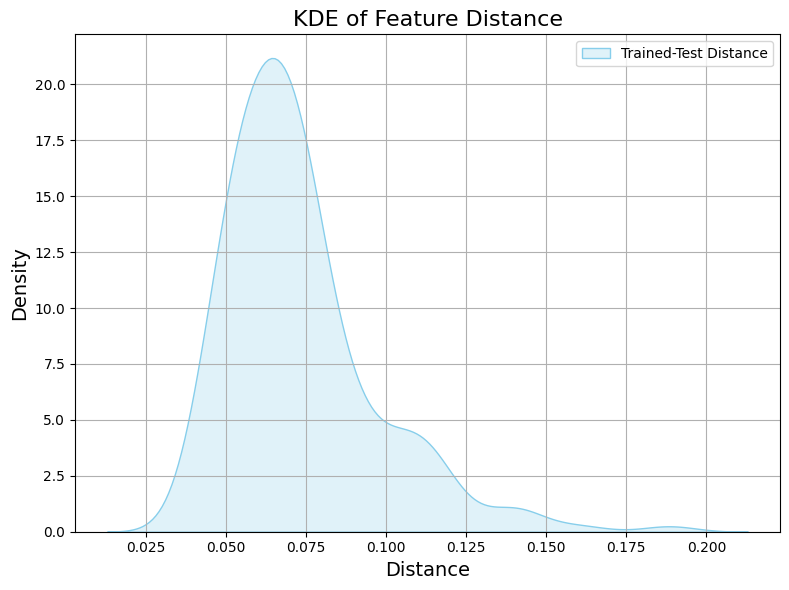

In [75]:
maml_distance_np = maml_distance.detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.kdeplot(maml_distance_np, shade=True, color="skyblue", label="Trained-Test Distance")
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("KDE of Feature Distance", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. MetaPro에 대한 Gaussian_Kernel_Density 계산하기

In [76]:
metapro_distance = torch.empty(0).cuda()

for i in range(len(MetaPro_training_feature_map)):
    dist = torch.cdist(
        MetaPro_training_feature_map[i].unsqueeze(0),  # shape: (1, 64)
        MetaPro_test_feature_map[i].unsqueeze(0)      # shape: (1, 64)
    )  # result: shape (1, 1)
    
    metapro_distance = torch.cat((metapro_distance, dist.view(1)), dim=0)  # flatten & accumulate

print(metapro_distance.shape)  # (B,

torch.Size([200])


C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  after removing the cwd from sys.path.


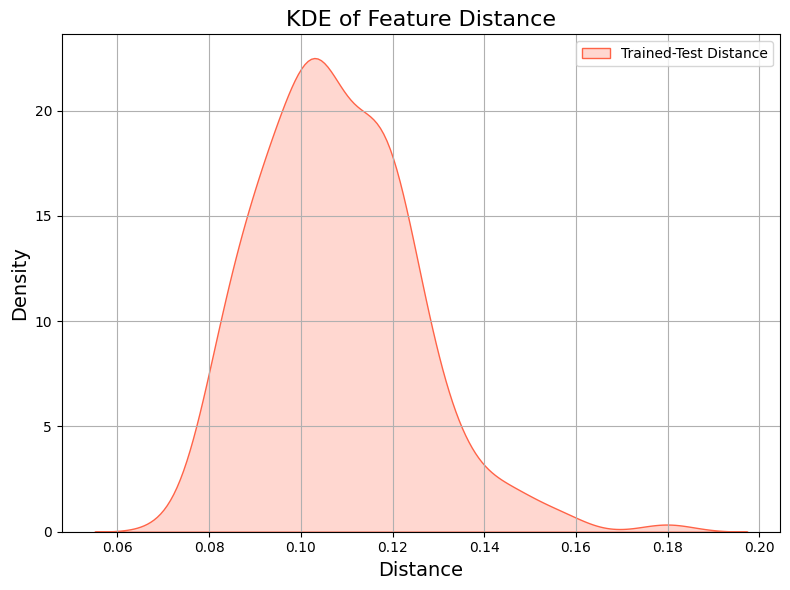

In [77]:
metapro_distance_np = metapro_distance.detach().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.kdeplot(metapro_distance_np, shade=True, color="tomato", label="Trained-Test Distance")
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("KDE of Feature Distance", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. 그래프 합치기

C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JM\anaconda3\envs\maml\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  after removing the cwd from sys.path.


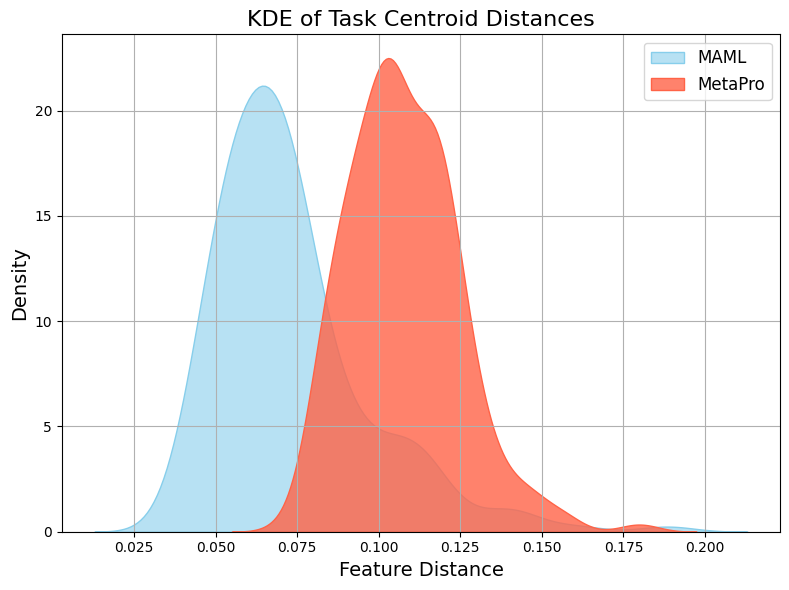

In [78]:
# KDE 그리기
plt.figure(figsize=(8, 6))
sns.kdeplot(maml_distance_np, shade=True, label="MAML", color="skyblue", alpha=0.6)
sns.kdeplot(metapro_distance_np, shade=True, label="MetaPro", color="tomato", alpha=0.8)

plt.xlabel("Feature Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("KDE of Task Centroid Distances", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("kde_metapro_vs_maml.png", dpi=300)
plt.show()